In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
for field in inspect(engine).get_columns('measurement'):
    print(field['name'], field['type'])
    #print(field.keys())
#session.query(Measurement).column_descriptions
#engine.execute("select min(date), max(date) from measurement limit 10").fetchall()


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
d_format = '%Y-%m-%d'
first_month = session.query(
    func.strftime(d_format,
    func.date(func.max(Measurement.date), '-1 year')
)).first()[0]
last_month = session.query(
    func.strftime(d_format,
    func.max(Measurement.date)
)).first()[0]
print(f"From {first_month} to {last_month}")

# Perform a query to retrieve the data and precipitation scores
# We take the max(date) so the last month can be incomplete month, let's exclude it
sel = [func.strftime(d_format, Measurement.date), func.avg(Measurement.prcp)]
twelve_months = session.query(*sel).\
    filter(func.strftime(d_format, Measurement.date) >= first_month).\
    filter(func.strftime(d_format, Measurement.date) <  last_month).\
    group_by(func.strftime(d_format, Measurement.date)).\
    order_by(func.strftime(d_format, Measurement.date)).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(twelve_months, columns=['Date', 'Prcp']).set_index('Date')

# Sort the dataframe by date
df.sort_index(inplace=True)

df.head()


From 2016-08-23 to 2017-08-23


,Prcp
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


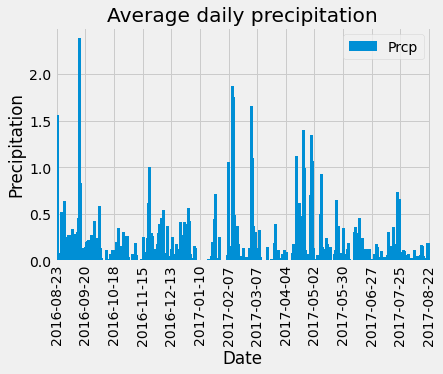

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
xticks_loc = np.arange(0, df.index.size, 28)
fig = plt.figure(figsize=(10, 6), dpi=200)
df.plot.bar(width=3)
plt.title("Average daily precipitation")
plt.ylabel("Precipitation")
plt.xticks(ticks = xticks_loc, labels= df.index[xticks_loc])
#plt.savefig('OneYearDailyAverage.png', bbox_inches='tight')
fig.show()
plt.close(fig)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Prcp
count,365.000000
mean,0.170862
std,0.296082
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station, func.min(Measurement.date), func.max(Measurement.date)) \
    .group_by(Measurement.station) \
    .order_by(Measurement.station) \
    .all()
print(pd.DataFrame(stations, columns=['station_id', 'start_date', 'end_date']))
print("Number of stations: ", len(stations))


station_id  start_date    end_date
0  USC00511918  2010-01-01  2015-10-30
1  USC00513117  2010-01-01  2017-07-31
2  USC00514830  2010-03-01  2017-08-23
3  USC00516128  2010-01-01  2017-08-23
4  USC00517948  2010-05-03  2017-07-31
5  USC00518838  2010-01-01  2015-11-20
6  USC00519281  2010-01-01  2017-08-18
7  USC00519397  2010-01-01  2017-08-23
8  USC00519523  2010-01-01  2017-08-23
Number of stations:  9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_measurements = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()
station_measurements

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)
).filter(Measurement.station == 'USC00519281') \
 .all()

[(54.0, 71.66378066378067, 85.0)]

In [17]:
# Choose the station with the highest number of temperature observations.
most_station = session.query(Measurement.station, func.count(Measurement.tobs)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.tobs).desc()) \
    .first()[0]
most_station

'USC00519281'

From 2016-08-18 to 2017-08-18


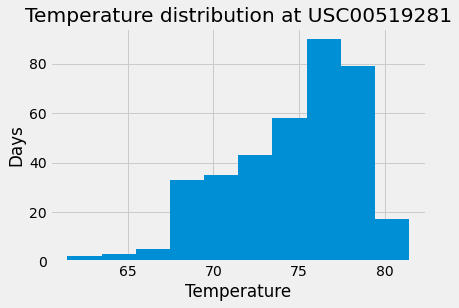

In [27]:

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
d_format = '%Y-%m-%d'
first_month = session.query(
    func.strftime(d_format,
    func.date(func.max(Measurement.date), '-1 year')
)).filter(Measurement.station == most_station).first()[0]
last_month = session.query(
    func.strftime(d_format,
    func.max(Measurement.date)
)).filter(Measurement.station == most_station).first()[0]
print(f"From {first_month} to {last_month}")

# Perform a query to retrieve the data and precipitation scores
# We take the max(date) so the last month can be incomplete month, let's exclude it
sel = [func.strftime(d_format, Measurement.date), func.avg(Measurement.tobs)]
twelve_months = session.query(*sel).\
    filter(func.strftime(d_format, Measurement.date) >= first_month).\
    filter(func.strftime(d_format, Measurement.date) <  last_month).\
    group_by(func.strftime(d_format, Measurement.date)).\
    order_by(func.strftime(d_format, Measurement.date)).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(twelve_months, columns=['Date', 'Temp']).set_index('Date')

# Sort the dataframe by date
df.sort_index(inplace=True)

df.hist()
plt.title(f"Temperature distribution at {most_station}")
plt.xlabel("Temperature")
plt.ylabel("Days")
#plt.savefig('OneYearTemparatureHistogram.png', bbox_inches='tight', dpi=200)
plt.show()


## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
